# Hi! 
### House Predection Competetion on Kaggle: https://www.kaggle.com/c/home-data-for-ml-course

### Achieved Performance (Top 3%)


In [1]:
import pandas as pd
import numpy as np

## for Plottng and Visualization
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.preprocessing import PolynomialFeatures

from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor


In [2]:
Train_data_org=pd.read_csv("train.csv")
Train_data_org.set_index("Id",inplace=True)
Test_data_org=pd.read_csv("test.csv")
Test_data_org.set_index("Id",inplace=True)
Train_data_shape=Train_data_org.shape
Test_data_shape=Test_data_org.shape
print("We have {0} Features\n{1} examples for Training  \n{2} examples for Testing \n ".format(Train_data_shape[1],Train_data_shape[0],Test_data_shape[0]))
print("This is a sample  from our data ")
Train_data_org.head()

We have 80 Features
1460 examples for Training  
1459 examples for Testing 
 
This is a sample  from our data 


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Explore skewness of the target(Sales Price)
###### We can see that logarthimict function improved skewness of the target value(helpful when using Linear Regression)--Suggested by Ref[1]

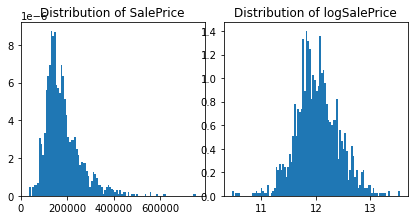

In [3]:
fig= plt.figure(figsize=(6,3))

plt.subplot(1, 2, 1)
plt.tight_layout()

target =Train_data_org.SalePrice
plt.hist(target,bins=100,density=True)
#plt.xticks(np.arange(min(target), max(target)+1, 100))
plt.title('Distribution of SalePrice')

target_log=np.log(target)
plt.subplot(1, 2, 2)

plt.hist(target_log,bins=100,density=True)
plt.title('Distribution of logSalePrice')
plt.show()

In [4]:
Numerical_Features=Train_data_org.select_dtypes(exclude=["object"]).drop(columns="SalePrice")
Categorical_Features=Train_data_org.select_dtypes(include=["object"])

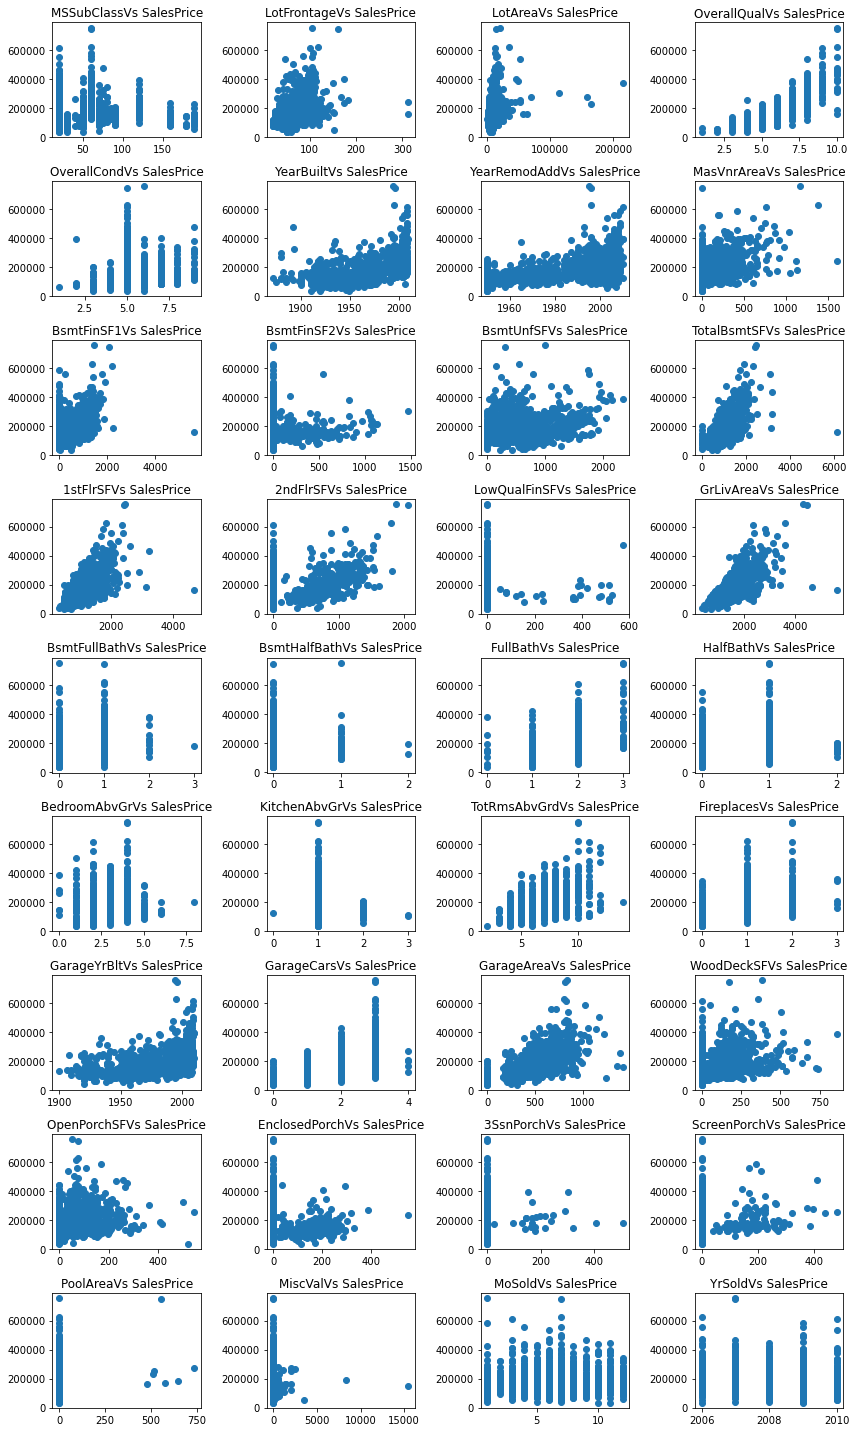

In [5]:
## ScatterPlot Analysis of Numerical Varables vs Target
fig= plt.figure(figsize=(12,20))
for i in range(len(Numerical_Features.columns)):
    fig.add_subplot(9, 4,i+1)
    plt.scatter(Numerical_Features.iloc[:,i],target)
    plt.title(Numerical_Features.columns[i]+"Vs SalesPrice")
plt.tight_layout()
plt.show()

In [6]:
### From the scatter plot above, There are obvious some outliers 
# remove Outliers from data

###### 1- Lot Frontage>200
###### 2- LotArea>100,000
###### 3- BsmntFinsS1> 4000
###### 4- MiscVal>5000
###### 5- GrLivArea >4000
###### 6- LowQualFinSF (>550)
###### 7- 1stFlrSF (>4000)



Train_data_copy =Train_data_org.copy()
Train_data_copy.drop(Train_data_copy.loc[Train_data_copy["LotFrontage"]>200].index,inplace=True)
Train_data_copy.drop(Train_data_copy.loc[Train_data_copy["LotArea"]>100000].index,inplace=True)
Train_data_copy.drop(Train_data_copy.loc[Train_data_copy["1stFlrSF"]>4000].index,inplace=True)
Train_data_copy.drop(Train_data_copy.loc[Train_data_copy["LowQualFinSF"]>550].index,inplace=True)
Train_data_copy.drop(Train_data_copy.loc[Train_data_copy["GrLivArea"]>4000].index,inplace=True)
Train_data_copy.drop(Train_data_copy.loc[Train_data_copy["MiscVal"]>5000].index,inplace=True)
Train_data_copy.drop(Train_data_copy.loc[Train_data_copy["BsmtFinSF1"]>4000].index,inplace=True)

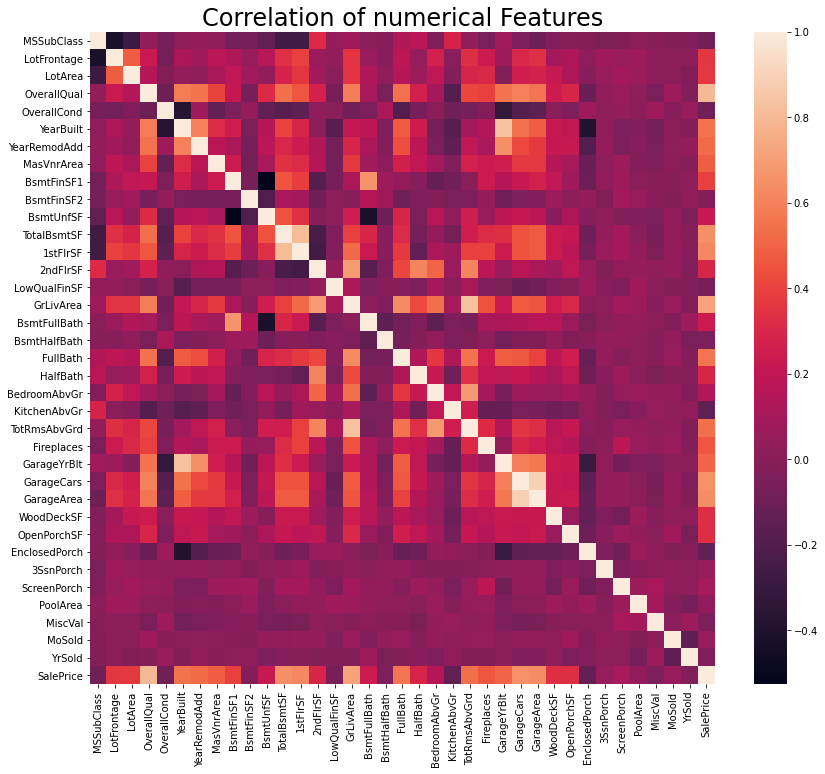

In [7]:
### Compute pairwise correlation of columns, default Pearson
correlation = Train_data_copy.corr()    
f, ax = plt.subplots(figsize=(14,12))
plt.title('Correlation of numerical Features', size=24)
sns.heatmap(correlation)
plt.show()

### Explore Mising Values

In [8]:
### First,Concatenating Train&Test Data to deal with missing values

Train_Features=Train_data_copy.drop(columns="SalePrice")
Test_Features=Test_data_org
All_Features=pd.concat([Train_Features,Test_Features]).reset_index(drop=True) 


# Convert numeric cols to categories -- It makes sense more for the House class and the month sold to be categorical features.
All_Features['MSSubClass'] = All_Features['MSSubClass'].apply(str)
All_Features['MoSold'] = All_Features['MoSold'].apply(str)

# Generate total square Feature
All_Features['TotalSF'] = All_Features['TotalBsmtSF'] + All_Features['1stFlrSF'] + All_Features['2ndFlrSF']
All_Features.drop(columns=['TotalBsmtSF','1stFlrSF','2ndFlrSF'],axis=1,inplace=True)

# # Generate total bathroom Feature
All_Features['TotalBathroom'] = All_Features['FullBath'] + All_Features['HalfBath']
All_Features.drop(['FullBath', 'HalfBath'],axis=1,inplace=True)

#############
num_Feats={}
cat_Feats={}
total_len=len(All_Features)
for i in All_Features.columns:
    sum_nan=All_Features[i].isna().sum()
    if sum_nan !=0 :
        if All_Features[i].dtype=='O':
            cat_Feats[i]=sum_nan
        else:
            num_Feats[i]=sum_nan
print("We have {0} of Numarical Features have Missing Values : \n\n".format(len(num_Feats)))
for key,i in num_Feats.items():
    print(key.ljust(20),"{:.2f}".format((i/total_len)*100),"%")
    
print("\n\n\nWe have {0} of Categorical Features have Missing Values : \n\n".format(len(cat_Feats)))
for key,i in cat_Feats.items():
    print(key.ljust(20),"{:.2f}".format((i/total_len)*100),"%")

We have 11 of Numarical Features have Missing Values : 


LotFrontage          16.55 %
MasVnrArea           0.79 %
BsmtFinSF1           0.03 %
BsmtFinSF2           0.03 %
BsmtUnfSF            0.03 %
BsmtFullBath         0.07 %
BsmtHalfBath         0.07 %
GarageYrBlt          5.47 %
GarageCars           0.03 %
GarageArea           0.03 %
TotalSF              0.03 %



We have 23 of Categorical Features have Missing Values : 


MSZoning             0.14 %
Alley                93.19 %
Utilities            0.07 %
Exterior1st          0.03 %
Exterior2nd          0.03 %
MasVnrType           0.83 %
BsmtQual             2.79 %
BsmtCond             2.82 %
BsmtExposure         2.82 %
BsmtFinType1         2.72 %
BsmtFinType2         2.75 %
Electrical           0.03 %
KitchenQual          0.03 %
Functional           0.07 %
FireplaceQu          48.81 %
GarageType           5.40 %
GarageFinish         5.47 %
GarageQual           5.47 %
GarageCond           5.47 %
PoolQC               99.72 %
Fence  

#### Filling Missing Values


In [9]:
# First, Numerical Values
# 1- LotFrontage , We will be filling,later, this using SimpleImputer

# 2-GarageYrBlt is highly corrolated (0.82) with YearBuilt so we can dicard it from our data.

print(correlation["GarageYrBlt"].loc[correlation["GarageYrBlt"]>0.8])
All_Features.drop(columns="GarageYrBlt",inplace=True)

# 3-MasVnrArea will be filled with 0 as likely there is no MasVnr for this house. 

All_Features["MasVnrArea"].fillna(0,inplace=True)

##########
##########

## Filling Categorical Values 
## Assume Most of  Categorical null values are actully "None"
none_cols = [
    'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]
for i in none_cols:
    All_Features[i].fillna(value='None',inplace=True)
    
# for the rest of cat features-- fill it with the most repeated value
for i in cat_Feats:
    max_cat=All_Features[i].unique()[All_Features[i].value_counts().argmax()]
    All_Features[i].fillna(max_cat,inplace=True)
    
    
##### Label Encoding All Categorical Features and drop original Categorical Features
for i in All_Features.columns:
    if All_Features[i].dtype=='O':
        le = LabelEncoder()
        All_Features[i+"_enc"]=le.fit_transform(All_Features[i])
        All_Features.drop(columns=i,inplace=True) 
        
s=SimpleImputer(strategy='mean')
All_Features_imp = pd.DataFrame(s.fit_transform(All_Features),columns=All_Features.columns)    
    
# fill in LotFrontage using Multivariate Imputation
#imp = IterativeImputer(max_iter=20, random_state=0)
#All_Features_imp=pd.DataFrame(imp.fit_transform(All_Features),columns=All_Features.columns)




YearBuilt      0.828756
GarageYrBlt    1.000000
Name: GarageYrBlt, dtype: float64


### Train Test Split

In [10]:
## Add the unskewed target(logSalePrice to our data)
Train_data_copy.LogSalePrice=np.log(Train_data_copy.SalePrice)

#Returning back to our Training and Testing Set and Creating a validation Set 
Train_data_imp=All_Features_imp.iloc[0:Train_data_copy.shape[0],:]
Test_data_imp=All_Features_imp.iloc[Train_data_copy.shape[0]:,:]


## TrainTestSplit -- 
## note: Target is LogSalePrice
X_train, X_valid, y_train, y_valid = train_test_split( Train_data_imp, Train_data_copy.LogSalePrice , test_size=0.15, random_state=40)


<ipython-input-10-a80f1c2b8053>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Train_data_copy.LogSalePrice=np.log(Train_data_copy.SalePrice)


#### Feature Selection

In [11]:
## Training With the selected features worsen the performance so I didnot use them

from sklearn.linear_model import LassoCV
from sklearn import linear_model
##LassoCv run the model on different alphas and choose the best based on cv error
clf = LassoCV(normalize=True).fit(X_train, y_train)

# Apply Feature Selection 
sfm = SelectFromModel(clf)
sfm.fit(X_train, y_train)
X_transform = sfm.transform(X_train)


X_train_selected_features=pd.DataFrame(sfm.inverse_transform(X_transform),columns=X_train.columns)
X_valid_selected_features=X_valid.copy()
test_data_selected_features=Test_data_imp.copy()
for i in X_train_selected_features.columns:
    if X_train_selected_features[i].mean()==0:
        X_train_selected_features.drop(columns=i,inplace=True)
        X_valid_selected_features.drop(columns=i,inplace=True)
        test_data_selected_features.drop(columns=i,inplace=True)


print("Number of Selected Features  {} \n".format(X_train_selected_features.shape[1]))  

for i in X_train_selected_features.columns:
    print(i)

Number of Selected Features  57 

LotFrontage
OverallQual
OverallCond
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
GrLivArea
BsmtFullBath
BsmtHalfBath
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageCars
GarageArea
WoodDeckSF
3SsnPorch
ScreenPorch
PoolArea
MiscVal
YrSold
TotalSF
TotalBathroom
MSSubClass_enc
MSZoning_enc
Street_enc
Alley_enc
LotShape_enc
LandContour_enc
Condition1_enc
Condition2_enc
BldgType_enc
RoofStyle_enc
RoofMatl_enc
Exterior2nd_enc
MasVnrType_enc
ExterQual_enc
ExterCond_enc
Foundation_enc
BsmtQual_enc
BsmtExposure_enc
BsmtFinType1_enc
HeatingQC_enc
CentralAir_enc
KitchenQual_enc
Functional_enc
FireplaceQu_enc
GarageType_enc
GarageQual_enc
GarageCond_enc
PavedDrive_enc
PoolQC_enc
Fence_enc
MoSold_enc
SaleType_enc
SaleCondition_enc


##### Let's Traiiiiin


In [12]:
##LassoModel .---> LinearRegression + L1 Regularization
parameters={'alpha':[0.5, 0.1, 0.001, 0.0005, 0.00005 ,0.00001]}
lasso_model_best = GridSearchCV(Lasso(normalize=True,random_state=5), parameters)
lasso_model_best.fit(X_train, y_train)
print("Best Value for Alpha is:",lasso_model_best.best_params_)

lasso_val_predictions = lasso_model_best.predict(X_valid)
lasso_val_mse = mean_squared_error(np.exp(lasso_val_predictions), np.exp(y_valid),squared=False)
print("lasso_val_mse",lasso_val_mse)

##Ridge Model---> LinearRegression + L2 Regularization
ridge_model_best = GridSearchCV(Ridge(normalize=True,random_state=5), parameters)
ridge_model_best.fit(X_train, y_train)
print("Best Value for Alpha is:",ridge_model_best.best_params_)

ridge_val_predictions = ridge_model_best.predict(X_valid)
ridge_val_mse = mean_squared_error(np.exp(ridge_val_predictions), np.exp(y_valid),squared=False)
print("ridge_val_mse",ridge_val_mse)


#### RandomForest Model
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train,y_train)
melb_preds = forest_model.predict(X_valid)
print("forest_val_mse",mean_squared_error(np.exp(y_valid), np.exp(melb_preds),squared=False))


Best Value for Alpha is: {'alpha': 5e-05}
lasso_val_mse 19365.2475166185
Best Value for Alpha is: {'alpha': 0.1}
ridge_val_mse 19312.179679087625
forest_val_mse 22254.625422429996


In [13]:
## Trying Polynomial Features with Lasso Model

# best_params turnned out to be alpha :5e-5 and degree of 1 , yes! hahaha so back to our beautiful Lasso Model

#pipeline = Pipeline([
#        ('poly', PolynomialFeatures()),
#        ('model', Lasso(normalize=True)),])

#parameters={"poly__degree":(1,2,3,4),"model__alpha":(0.5, 0.1, 0.001, 0.0005, 0.00005 ,0.00001)}

#gsc=GridSearchCV(pipeline,parameters,cv=5)

#gsc.fit(X_train,y_train)
#gsc.best_params_


In [14]:
pred=forest_model.predict(Test_data_imp)
sub=pd.DataFrame({"Id":Test_data_org.index,"SalePrice":np.exp(pred)})
sub.to_csv("sub.csv",index=False)


###  Great Performance(Top 3%)  
### After adding the new Features(# of baths and TotalArea ) rank improved from 10% to 3%  
pred2=lasso_model_best.predict(Test_data_imp)
sub2=pd.DataFrame({"Id":Test_data_org.index,"SalePrice":np.exp(pred2)})
sub2.to_csv("sub_Lasso.csv",index=False)



References:
These two notebooks were too helpful
    
https://www.kaggle.com/cheesu/house-prices-1st-approach-to-data-science-process
    
Improvin my model by adding new Features    
https://www.kaggle.com/ttminh27/house-price-competition-how-i-archive-top-3
    
    